# Bandit problem solutions

This code contains epsilon-Greedy and Thompson Sampling algorithms for Bernoulli bandit problem.
Also, it solves Gaussian Bandit problem by Upper-Confidence Bound and Thompson Sampling algorithms.

As a simulation, a task for Correlated Travel Times was solved using Thomson Sampling algorithm. 



### Prepare te environment

In [1]:
!pip install Dijkstar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
from dijkstar import Graph, find_path
from copy import deepcopy
import matplotlib.pyplot as plt

### Base class
While writing solutions to these problems, I noticed that all the algorithms have the same structure. Before the game starts, the parameters of prior distribution are set. Then, at each time period, the attractiveness of each action is evaluated and one of them is chosen based on this. After that, the action is performed and some reward is awarded for it. The posterior distribution is calculated based on this and the prior is updated for the next time period. Additionally, the regret can be counted as the received reward minus the best one that could be obtained at that moment.

So, I decided to use OOP to solve the problem elegantly.

GeneralBanditAlgorithm is a class that implements the main function - the solution as a sequence of steps discussed earlier. Each step is a function call that can be rewritten by child classes. The function that displays the information is also realized here. Note that all other algorithms are its childs, and them all has original\_param1 and original\_param2 as data from the real world, estimated\_param1 and estimated\_param2 as parameters for prior distribution. 

In [3]:
class GeneralBanditAlgorithm:
    """
    A class describing a general algorithm. It could not work itself - only inherited classes can run.
    Describes the general for all bandit problems solution flow.
    Also implements general for realized solutions methods. Note that they can be overwritten by inherited classes.
    Action is an index from 0 to len(original parameter 1).
    Each action has its corresponding original and estimated parameters 1 and 2.
    In all implemented algorithms, except simulation, only one action is chosen at each time period.
    """

    def __init__(self, p1, p2, init_p1, init_p2):
        """
        Initializes 2 parameters for both estimation and original (from real world).
        The parameters are given by inherited classes.

        :param p1: first parameter that represents data from real world (likelihood).
                    For Bernoulli problem - theta, for Gaussian - mu.
        :param p2: second parameter that represents data from real world (likelihood) !!!
                    For Bernoulli problem - 1- theta, for Gaussian - sigma.
        :param init_p1: prior about first parameter.
        :param init_p2: prior about second parameter.
        """
        self.original_param1 = p1
        self.original_param2 = p2
        self.estimated_param1 = init_p1
        self.estimated_param2 = init_p2
        # Counts how many times each action is performed
        self.steps_done = np.zeros(len(self.original_param1))
        # Calculate overall reward
        self.reward = 0
        # Saves regrets during for each time period
        self.regrets = np.array([])

    def find_solution(self, number_trials=100):
        """
        The general for all bandit problems solution flow. Calling methods may be overwritten.
        :param number_trials: number of time periods
        """
        for t in range(number_trials):
            # Estimate the reward for all possible actions based on prior distribution
            theta_est = self.estimate_reward()
            # Choose the most beneficial decision based on current knowledge
            actions = self.get_action(theta_est)
            # Obtain the real reward for all possible steps
            rewards = self.get_reward()
            # Update reward
            self.reward += sum([rewards[action] for action in actions])
            # Calculate regret for current time period
            self.calculate_regret(rewards, actions)
            # Get posterior distribution and update prior for the next time period based on it
            self.update_params(actions, rewards)

    def estimate_reward(self) -> list:
        """
        Estimate reward based on prior distribution. Must be overwritten by the inherited classes.
        :return: list of estimated reward for each action
        """
        pass

    def get_action(self, theta_est):
        """
        Find the best action to perform.
        The basic approach is implemented - chooses the one with the maximal value
        :param theta_est: assumed parameters
        :return: index of the maximal value
        """
        return [np.argmax(theta_est)]

    def get_reward(self) -> list:
        """
        Obtain reward from the real world. Must be overwritten by the inherited classes.
        :return: list of real reward for each action.
        """
        pass

    def update_params(self, actions, ys):
        """
        Get posterior distribution. Recalculate prior for the next time period based on the posterior of current.
        :param actions: list of the performed actions.
        :param ys: list of rewards obtained while making a step on the action.
        """
        pass

    def calculate_regret(self, rewards, actions):
        """
        Calculate regret for given time period
        :param rewards: rewards from real world
        :param actions: performed actions
        """
        self.regrets = np.append(self.regrets, [max(self.original_param1) - self.original_param1[actions[0]]])

    def plot_regret(self):
        """
        Plot regrets
        """
        plt.plot(*range(0, len(self.regrets)), self.regrets, scaley=True)
        plt.ylim(top=max(self.regrets))
        plt.ylim(bottom=min(0, min(self.regrets)))
        plt.ylabel('Regrets')
        plt.xlabel('Time period')
        plt.show()

    def print_result(self):
        """
        Print general information
        """
        best_action = self.get_action(self.original_param1)
        est_action = self.get_action(self.get_estimated_parameter())
        count = 0
        for i in range(len(best_action)):
            if best_action[i] == est_action[i]:
                count += 1
        if count == len(best_action):
            print("The best solution was found correctly: ", *best_action)
        else:
            print("Obtained solution is not the same as the real")
            print("The best solution: ", *best_action)
            print("The obtained solution: ", *est_action)
            best_score = sum([self.original_param1[a] for a in best_action])
            est_score = sum([self.original_param1[a] for a in est_action])
            if best_score >= est_score:
                print(f"The score of the best solution is {best_score - est_score} units bigger than of the estimated.")
            else:
                print(f"The score of the estimated solution is {est_score - best_score} units bigger than of the best.")

        print("Steps done for each action: ", self.steps_done)
        print("With reward score %.2f through all time periods" % self.reward)
        print()
        print("Result of estimation is ", self.get_estimated_parameter())
        print("While the real is ", self.original_param1)
        print("With Mean Absolute Error: %.3f" % (
                sum(np.abs(self.original_param1 - self.get_estimated_parameter())) / len(self.original_param1)))
        print()

    def get_estimated_parameter(self):
        """
        :return: estimated parameter
        """
        return self.estimated_param1


The following function runs the algorithms many times and plot per-period regret

In [32]:
def plot_regret(n_trials, time, algorithm, params, min_before, max_before):
    """
    Plot the average over n_trials regret for the algorithm.
    :param n_trials: number of algorithm runs
    :param time: number of time periods on which run the algorithm
    :param algorithm: algorithm to be used
    :param params: algorithm parameters, such as epsilon or confidence
    :param min_before: lower bound along the y-axis of the plot
    :param max_before: upper bound along the y-axis of the plot
    :return: lower and upper bounds along the y-axis of the plot
    """
    regrets = np.zeros(time)
    for i in range(n_trials):
        # Run algorithm for time periods
        alg = algorithm(*params)
        alg.find_solution(time)
        # Update regrets
        regrets = regrets + alg.regrets
    # Take average over all regrets
    regrets = regrets / n_trials
    plt.plot(*range(0, len(regrets)), regrets)
    return min(min_before, min(regrets)), max(max_before, max(regrets))


### Bernoulli bandit problem

Imagine that there is a machine with many arms, each of them has a probability of winning. A player comes in. He wants to get as many wins as possible. The intuitive solution is to hold the hand with the highest success probability. However, the player does not know these probabilities. In this case, he can follow different strategies, some of which are implemented in this solution (epsilon-Greedy, Thompson Sampling). Note that this is a bandit problem with Bernoulli's reward: the player pulls a bandit's arm and with some probability wins (receives +1 reward) or loses (receives +0 reward). 

In [5]:
class BernoulliBandit(GeneralBanditAlgorithm):
    """
    Implements Bernoulli Bandit problem. It could not work itself - only inherited classes can run.
    An action is pulling the arm. It is an index of the corresponding parameters.
    The reward of the action is 1 in case of success or 0 otherwise.
    The player does not know the real success probabilities of the arms, so tries to estimate it by making actions.
    """

    def __init__(self, arms_num=3, probabilities=None):
        """
        Set initial parameters.
        Likelihood (data from the real world): parameter 1 is probabilities, parameter 2 is 1-probabilities.
                    So it is a Beta distribution with alpha=probabilities, beta=(1-probabilities).
        Prior distribution: beta-distribution parameter 1 is alpha (number of positive outcomes),
                                              parameter 2 is beta (number of negative outcomes).
        :param arms_num: number of bandit's arms
        :param probabilities: list of success probability for each arm
        """
        if probabilities is None:
            # Set random probabilities
            probabilities = np.random.rand(arms_num)
        probabilities = np.array(probabilities)
        super().__init__(probabilities, 1 - probabilities, np.ones(len(probabilities)), np.ones(len(probabilities)))

    def get_reward(self):
        """
        Obtain reward from the bandit: 1 in case of success and 0 otherwise.
        Random number from 0 to 1 is compared with the success probability of arm.
        The greater the probability, the greater the chance to win (when the random number is in range [0, probability])
        :return: list of the real reward for each arm.
        """
        theta = self.original_param1 / (self.original_param1 + self.original_param2)
        get_result = np.vectorize(lambda x: [1 if np.random.rand(1)[0] <= x else 0][0])
        return get_result(theta)

    def update_params(self, actions, ys):
        """
        Update alpha, beta and amount of steps based on the performed actions
        :param actions: list of indices of performed actions
        :param ys: list of observed values
        """
        for action in actions:
            self.estimated_param1[action] += ys[action]
            self.estimated_param2[action] += 1 - ys[action]
            self.steps_done[action] += 1

    def get_estimated_parameter(self):
        """
        Calculate probability of win as expected value of the estimated distribution
        :return: probability estimated so far
        """
        return self.estimated_param1 / (self.estimated_param1 + self.estimated_param2)


#### Solution 1. Epsilon-Greedy algorithm
In this algorithm the prior distribution is set as beta distribution with parameters $estimated\_param1=alpha=1$, $estimated\_param2=beta=1$ for each hand. The real probabilities of each arm are stored in original\_param1 and set as a random number from 0 to 1. 

The estimated success probability (theta) of each arm is the expectation of the prior distribution: $alpha/(alpha+beta)$.  Every time-period with probability epsilon the player polls a random arm with probability proportional to the expected reward, otherwise he takes the action with the highest theta.

Regret counts as the difference between the real winning probability of the chosen arm and the highest possible success probability.

Note that the real reward is 1 if the chosen arm wins, or 0 otherwise. Victory is determined whether the random number is less than the real arm's success probability.
At each time period,  only the selected arm's posterior is calculated and its prior for the next step is updated: $alpha=alpha+reward$, $beta=beta+1-reward$. 


In [21]:
class BernoulliEGreedy(BernoulliBandit):
    """
    Implements Epsilon-Greedy Solution for Bernoulli Bandit problem.
    Chooses a random arm with probability epsilon, or take the action with the best expectation.
    """

    def __init__(self, epsilon=0.05, arms_num=3, probabilities=None):
        """
        Initialize parameters
        :param epsilon: probability of pulling a random arm
        :param arms_num: number of bandit's arms
        :param probabilities: list of success probability for each arm
        """
        super().__init__(arms_num, probabilities)
        self.epsilon = epsilon

    def estimate_reward(self):
        """
        Calculate reward based on prior distribution. Reward is the expected value of beta distribution
        with the observed so far alpha and beta (parameters 1 and 2, respectively).
        :return: list of expectations for each action
        """
        theta_est = np.ones(len(self.estimated_param1))
        for k in range(len(self.estimated_param1)):
            theta_est[k] = self.estimated_param1[k] / (self.estimated_param1[k] + self.estimated_param2[k])
        return theta_est

    def get_action(self, theta_est):
        """
        Find the action to perform. 
        With probability epsilon takes a random arm with probability proportional to the expected reward,
        otherwise takes the action with the best expectation.
        :param theta_est: list of expected reward for each action
        :return: index of the action
        """
        if np.random.rand() < self.epsilon:
            # Explore the random arm
            probabilities = theta_est/sum(theta_est)
            p = np.random.rand()
            cummulative_prob = 0
            for i in range(len(probabilities)):
                cummulative_prob += probabilities[i]
                if p <= cummulative_prob:
                    return [i]
            return [len(theta_est)-1]
        else:
            # Exploit the best arm
            ind = np.argmax(theta_est)
        return [ind]


In [24]:
solution = BernoulliEGreedy(0.1)
solution.find_solution(1000)
solution.print_result()

The best solution was found correctly:  1
Steps done for each action:  [ 18. 952.  30.]
With reward score 958.00 through all time periods

Result of estimation is  [0.35       0.97589099 0.71875   ]
While the real is  [0.25299063 0.97812402 0.66689025]
With Mean Absolute Error: 0.050



#### Solution 2. Thompson Sampling algorithm
This algorithm differs from the epsilon greedy algorithm in not using epsilon. Theta (estimated success probability) is taken as a sample from the prior distribution (with parameters estimated\_param1 as alpha & estimated\_param2 as beta), and the action is chosen as the arm with the highest theta.

In [26]:
class BernoulliTS(BernoulliBandit):
    """
    Implements Thompson Sampling Solution for Bernoulli Bandit problem.
    """

    def __init__(self, arms_num=3, probabilities=None):
        """
        Initialize parameters
        :param arms_num: number of bandit's arms
        :param probabilities: list of success probability for each arm
        """
        super().__init__(arms_num, probabilities)

    def estimate_reward(self):
        """
        Estimate reward as a sample from normal distribution with parameters mu and sigma
        :return: lost of samples from the distributions
        """
        theta_est = np.ones(len(self.estimated_param1))
        for k in range(len(self.estimated_param1)):
            theta_est[k] = np.random.beta(self.estimated_param1[k], self.estimated_param2[k])
        return theta_est


In [ ]:
solution = BernoulliTS()
solution.find_solution(1000)
solution.print_result()

The best solution was found correctly:  0
Steps done for each action:  [918.  72.  10.]
With reward score 871.00 through all time periods

Result of estimation is  [0.87717391 0.82432432 0.5       ]
While the real is  [0.87354905 0.81792862 0.40618663]
With Mean Absolute Error: 0.035



#### Graph of regrets per period for both solutions
I ran the algorithms for the Bernoulli reward for 1000 time periods 10000 times and got the following graph. From it one can notice that Thompson's algorithm converges better than the epsilon-greedy algorithm.


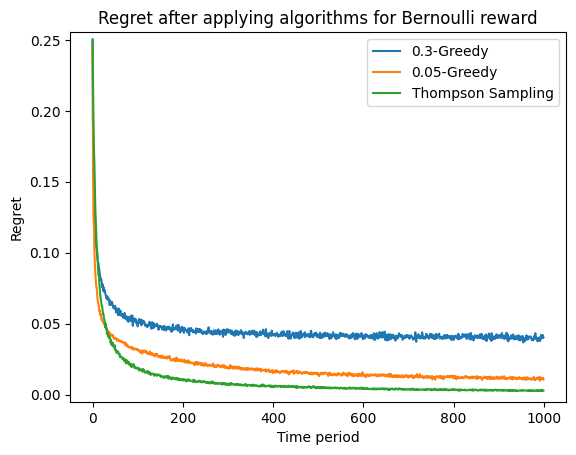

In [36]:
n_trials = 10000
periods = 1000
lower_bound, upper_bound = 0, 0
lower_bound, upper_bound = plot_regret(n_trials, periods, BernoulliEGreedy, [0.3], lower_bound, upper_bound)
lower_bound, upper_bound = plot_regret(n_trials, periods, BernoulliEGreedy, [0.05], lower_bound, upper_bound)
lower_bound, upper_bound = plot_regret(n_trials, periods, BernoulliTS, [], lower_bound, upper_bound)

lower_bound -= (upper_bound-lower_bound)/50
upper_bound += (upper_bound-lower_bound)/50
plt.ylim(top=upper_bound)
plt.ylim(bottom=lower_bound)

plt.ylabel('Regret')
plt.xlabel('Time period')
plt.legend(["0.3-Greedy", "0.05-Greedy",  "Thompson Sampling"])
plt.title("Regret after applying algorithms for Bernoulli reward")
plt.show()

### Gaussian Bandit problem
Now suppose that each hand produces a reward as a real value from a normal distribution. My solution assumes that the hands have different mean values, but the same variance equal to 1. The player knows variance, but does not know means and wants to maximize his reward. This is the Bandit problem with Gaussian rewards, for which I implemented UCB and Thompson Sampling algorithms. 

In [ ]:
class GaussianBandit(GeneralBanditAlgorithm):
    """
    Implements Gaussian Bandit problem. It could not run itself - only inherited classes can be used.
    An action is pulling the arm. It is an index of the corresponding parameters.
    The reward is the real number - sample from the normal distribution.
    The player does not know the real mean of the arms, so tries to estimate it by making actions.
    Parameter 1 is a mean of the distribution, what we will estimate, parameter 2 is a variance, known for the player.
    """

    def __init__(self, mus=None, sigmas=None, elements_num=3):
        """
        Set initial parameters
        :param mus: predefined means
        :param sigmas: predefined variances
        :param elements_num: number of bandit's arms
        """
        if mus is None:
            # random initialization of real means
            mus = np.random.uniform(1, 10, elements_num)
        if sigmas is None or len(mus) != len(sigmas):
            # set all real variances as 0
            sigmas = np.ones(len(mus))
        # Prior is mean=0, sigma=100
        super().__init__(mus, sigmas, np.zeros(len(mus)), np.ones(len(mus)) * 100)

    def get_reward(self):
        """
        Obtain real reward as a sample from normal distribution with original (from the real world) parameters
        :return: list of each arm's sample from the distribution
        """
        return np.random.normal(self.original_param1, self.original_param2 ** 0.5, size=len(self.original_param1))

    def update_params(self, actions, ys):
        """
        Update mean and variance based on the performed actions.
        Next prior is the current posterior.
        :param actions: list of indices of performed actions
        :param ys: list of observed values
        """
        for action in actions:
            mu_est, sigma_est, n_trial, y, original_sigma = self.estimated_param1[action], \
                                                            self.estimated_param2[action], \
                                                            self.steps_done[action], ys[action], \
                                                            self.original_param2[action]
            # Calculate posterior
            mu_est = mu_est / sigma_est + y / original_sigma
            sigma_est = 1 / (1 / sigma_est + 1 / original_sigma)
            mu_est = mu_est * sigma_est
            n_trial += 1
            # Update prior
            self.estimated_param1[action], self.estimated_param2[action], self.steps_done[
                action] = mu_est, sigma_est, n_trial


#### Solution 1. Upper-Confidence Bound algorithm
In this algorithm the real reward (likelihood) for each arm is taken from normal distribution with $mean=original\_param1$ and $variance=original\_param2=1$. Note that mean is taken as random number from 1 to 10, the player does not know it. However, he knows that real variance are all equal to 1. 
Before the start the player set the prior distribution as normal with parameters $estimated\_param1=mu=0$, $estimated\_param2=sigma^2=1$ for each arm. \\
The expected reward (theta) of each arm is equal to the $exploitation\_part + confidence\_factor*exploration\_part$, where exploitation\_part is the expectation of the prior distribution; confidence\_factor is a constant during algorithm initialization, which represents how interested we are in exploring arms; $exploration\_part = \sqrt{\frac{\ln{N+1}}{n+1}}$, n is a number of pulling the arm, N is the overall number of performed trials. Every time-period the arm with the highest theta is taken. 

The real reward is a sample from likelihood. Regret counts as the difference between the obtained reward and the maximal possible. 
The posterior is calculated and prior is updated as conjugate distributions:

$
\mu_{posterior} = \frac{1}{\frac{1}{\sigma^2_{prior}} + \frac{1}{\sigma^2_{likelihood}}}(\frac{\mu_{prior}}{\sigma^2_{prior}} + \frac{reward}{\sigma^2_{likelihood}})
$

$\sigma_{posterior} = \frac{1}{\frac{1}{\sigma^2_{prior}} + \frac{1}{\sigma^2_{likelihood}}}$


In [ ]:
class GaussianUCB(GaussianBandit):
    def __init__(self, confidence=1, mus=None, sigmas=None, elements_num=3):
        """
        Set initial parameters.
        :param confidence: constant that manages the level of exploration
        :param mus: predefined means
        :param sigmas: predefined variances
        :param elements_num: number of bandit's arms
        """
        self.confidence = confidence
        super().__init__(mus=mus, sigmas=sigmas, elements_num=elements_num)

    def estimate_reward(self):
        """
        Estimate reward as an upper confidence bound: E + confidence * sqrt(ln(N+1)/(n+1)),
        where E is the expected value of the distribution, n - number of actions performed by the arm,
        N - total number of performed actions.
        :return: UCB for each arm
        """
        theta_est = np.ones(len(self.estimated_param1))
        for k in range(len(self.estimated_param1)):
            theta_est[k] = self.estimated_param1[k] + \
                           self.confidence * np.sqrt(np.log(sum(self.steps_done) + 1) / (self.steps_done[k] + 1))
        return theta_est


In [ ]:
solution = GaussianUCB(5)
solution.find_solution(1000)
solution.print_result()

The best solution was found correctly:  0
Steps done for each action:  [569.   2. 429.]
With reward score 8126.57 through all time periods

Result of estimation is  [8.17902695 0.49621223 8.09216642]
While the real is  [8.2901162  1.03808562 8.07671122]
With Mean Absolute Error: 0.223



#### Solution 2. Thompson Sampling algorithm
This algorithm differs from the UCB algorithm in not using confidence factor, theta estimation and arm choosing. 
Theta (estimated success probability) is taken as a sample from the prior distribution (with parameters estimated\_param1 as mean & estimated\_param2 as variance), and the action is chosen as the arm with the highest theta.


In [ ]:
class GaussianTS(GaussianBandit):
    """
    Implements Thompson Sampling Solution for Gaussian Bandit problem.
    Means are unknown, variances are known.
    """

    def __init__(self, mus=None, sigmas=None, elements_num=3):
        """
        Set initial parameters.
        :param mus: predefined means
        :param sigmas: predefined variances
        :param elements_num: number of bandit's arms
        """
        super().__init__(mus=mus, sigmas=sigmas, elements_num=elements_num)

    def estimate_reward(self):
        """
        Estimate reward as a sample from normal distribution
        :return: samples from the distributions
        """
        return np.random.normal(self.estimated_param1, self.estimated_param2 ** 0.5)


In [ ]:
solution = GaussianTS()
solution.find_solution(1000)
solution.print_result()

The best solution was found correctly:  1
Steps done for each action:  [  4. 995.   1.]
With reward score 7820.73 through all time periods

Result of estimation is  [6.27426802 7.83216124 2.46344812]
While the real is  [6.71623131 7.83484855 1.57013856]
With Mean Absolute Error: 0.446



#### Graph of regrets per period for both solutions
I ran the algorithms for the Gaussian reward for 500 time periods 10000 times and got the following graph. From it one can notice that Thompson's algorithm converges the best.


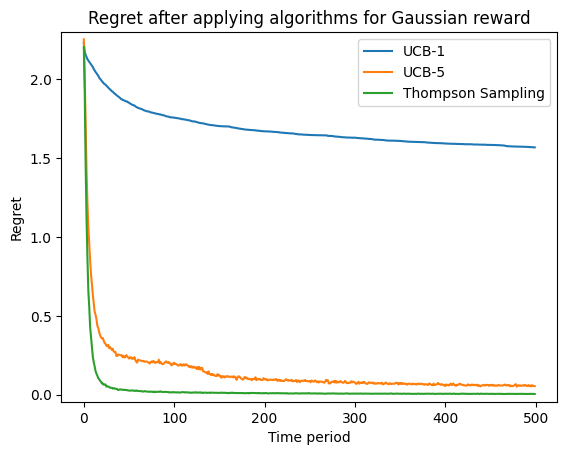

In [ ]:
n_trials = 10000
lower_bound, upper_bound = 0, 0
lower_bound, upper_bound = plot_regret(n_trials, 500, GaussianUCB, [1], lower_bound, upper_bound)
lower_bound, upper_bound = plot_regret(n_trials, 500, GaussianUCB, [5], lower_bound, upper_bound)
lower_bound, upper_bound = plot_regret(n_trials, 500, GaussianTS, [], lower_bound, upper_bound)

lower_bound -= (upper_bound-lower_bound)/50
upper_bound += (upper_bound-lower_bound)/50
plt.ylim(top=upper_bound)
plt.ylim(bottom=lower_bound)

plt.ylabel('Regret')
plt.xlabel('Time period')
plt.legend(["UCB-1", "UCB-5", "Thompson Sampling"])
plt.title("Regret after applying algorithms for Gaussian reward")
plt.show()


### Simulation
The Correlated Travel Time problem is the problem of finding the optimal path in the context of unknown travel time on each road. Imagine that a person travels from home (source) to work (destination) every day. The roads between them create a binomial bridge. Note that all edges between the origin and the middle are in the upper half, the rest are in the lower half.


The person wants to spend as less time on the road as possible, but does not know which route is faster. In reality, the travel time on each road at each day (time period) is a sample from lognormal distribution with parameters mu and sigma. Suppose in this problem the person does not know only the average travel time along each edge, and the sigma for all is 1.  The problem is complicated by the fact that the choice of one road affects the travel time on the other road, which is expressed in the covariance matrix, which the person also knows. 
$
\Sigma_{e_1, e_2} = \begin{cases}
\sigma^2 & e_1 = e_2 \\
\frac{2 \sigma^2}{3} & e_1 \neq e_2, \text{both in one half of bridge} \\
\frac{\sigma^2}{3} & \text{otherwise}
\end{cases}
$

Since I will be working mostly with edges, I represented one action as the choice of a road, and in one period of time the person chooses several edges. Therefore, the dimension of means is $E\times 1$, and for the covariance matrix it is $E\times E$, where E is the number of edges. Also, now the sample from the prior and likelihood distributions are taken as exponent in the power of sample from multivariate normal distribution of means and covariance matrix.

Moreover, the reward is multiplied by idiosyncratic\_factor, time\_factor and halves\_factor taken from the lognormal distribution with parameters $(-1/6 \sigma^2, 1/3 \sigma^2)$. Idiosyncratic\_factor represent some obstacles on each road, time\_factor is common for all edges, for example, today's weather, halves\_factor is the same for one half of the binomial bridge (one for upper half, another - for lower). 

Note that the task is to minimize the reward, or one can multiply reward by $-1$ and solve the maximization problem. When estimated rewards for each edge is calculated (using sample from prior distribution and parameters), the best path is chosen by Dijkstra's algorithm as one with the minimal path length. Then, the real rewards are obtained, and the reward for this time period is the sum of the edges rewards along the chosen path. The regret counts as the difference between the obtained reward and the minimal possible (calculated again with the Dijkstra's algorithm).

In [37]:
class CorrelatedTravelTimeSolution(GeneralBanditAlgorithm):
    """
    Implements Simulation of Exercise 4.2 from Tutorial "Correlated Travel Times".
    There is a binomial bridge from source to destination. A player wants to ride over the road (edge) with the minimal
    travel time. However, he does not know the optimal one. So, the player rides over different edges and tries to find
    the best one.
    Each edge has its mean travel time and its variance. For this simulation let's consider that all edges has the same
    variance, and the player knows it. Travel time on one edge may depend on the other, that is represented by the
    covariance matrix. So, when the player drives a route, the travel time on each edge is a
    sample from log-Gaussian multivariate distribution with vector of means and covariance matrix as its parameters.
    Also, each day there are 3 coefficients: idiosyncratic_factor, time_factor and halves_factor,
    that change the preferences of the road during each time period. More information about them see in
    CorrelatedTravelTimeSolution.set_additional_parameters().
    Indexing starts from 0. Action is the list of edges that creates a path from source to destination.
    """

    def __init__(self, number_stages=6, original_means=None, original_sigma=1):
        """
        Set initial estimations. Construct bridge and mappings to it.
        The unknown parameter for the player is mean that is set as a random number from [0,5] - it is original_param2.
        Sigma (original_param2) is a known parameter that is equal to 1. It may be a vector, but for this simulation
        we considered a case of equal variance for all roads. Based on it the covariance matrix is calculated.

        :param number_stages: length of the path in the binomial bridge
        :param original_means: real means for each edge
        :param original_sigma: variance of the travel time though the edges
        """
        # Create graph and mapping to it
        self.half_length = number_stages // 2 + 1
        self.graph = self.create_binomial_graph()
        self.edges_mapping = self.map_edge_vertices()

        # Set initial parameters
        if original_means is None or len(original_means) != len(self.edges_mapping):
            original_means = np.random.rand(len(self.edges_mapping)) * 5
        super().__init__(original_means, original_sigma, np.ones(len(self.edges_mapping)) * (-0.5),
                         np.identity(len(original_means)))
        self.original_covariance = self.calculate_variance_matrix()
        self.concentrations = np.linalg.inv(self.original_covariance)

        # Set initial factors. Will be overwritten at each time period.
        self.idiosyncratic_factor = np.ones(len(self.original_param1))
        self.time_factor = 1
        self.halves_factor = np.ones(2)

    def construct_half(self):
        """
        Construct an upper half of the binomial bridge. This implementation assumes that the upper half of the bridge
        is all edges between the source and vertices in the middle of the bridge. 
        Correspondingly, all other roads belong to the lower half.
        :return: array of connections. The index is the index of vertex, and values is the list of vertices that are
        directly connected to it.
        """
        connections = []
        vertex_counter = 0

        for i in range(1, self.half_length):
            for vert in range(vertex_counter, vertex_counter + i):
                connections.append([vert + i, vert + i + 1])
            vertex_counter += i
        return connections

    def create_binomial_graph(self):
        """
        Construct binomial graph. Note that one vertex may have an edge to at most 2 other vertices (edges are directed)
        :return: array of connections. The index is the index of vertex, and values is the list of vertices that are
        directly connected to it.
        """
        # Add upper half to the full list of connections
        connections = self.construct_half()

        # Extend list of connections to add the lower half of the bridge
        for i in range(sum([*range(self.half_length, 0, -1)]) - 1):
            connections.append([])

        # Create lower half as upper and invert it
        lower_half = self.construct_half()
        mapping = [i + len(lower_half) - 1 for i in range(sum([*range(self.half_length, 0, -1)]), 0, -1)]

        for i in range(len(lower_half)):
            for vert in list(lower_half[i]):
                # Add in a sorted way
                if len(connections[mapping[vert]]) > 0 and mapping[i] < connections[mapping[vert]][0]:
                    connections[mapping[vert]].insert(0, mapping[i])
                else:
                    connections[mapping[vert]].append(mapping[i])
        return connections

    def map_edge_vertices(self):
        """
        Create mapping edge index -> [source_vertex, destination_vertex].
        :return: array of mapping for each edge
        """
        arr = []
        for s in range(len(self.graph)):
            for d in self.graph[s]:
                arr.append([s, d])
        return arr

    def calculate_variance_matrix(self):
        """
        Calculate concentration matrix for all edges.
        Firstly calculate covariance matrix as given variance multiplied by covariance coefficient:
        1 for the same edge, 2/3 for the edge in the same half of binomial graph, 1/3 otherwise.
        Then calculate the inverse of the covariance matrix that is a concentration matrix.
        Note that before using the concentration matrix edges that are not in the path must be marked as 0.
        :return: inverse of covariance matrix
        """
        covariance = []
        half_ind = len(self.edges_mapping) // 2
        for i in range(len(self.edges_mapping)):
            # Calculate covariance matrix
            covariance.append([])
            for j in range(len(self.edges_mapping)):
                if i == j:
                    # Diagonal element - this edge itself.
                    covariance[i].append(1 * self.original_param2)
                elif (i < half_ind and j < half_ind) or (i >= half_ind and j >= half_ind):
                    # They are in one half of binomial bridge
                    covariance[i].append(self.original_param2 * 2 / 3)
                else:
                    # They are in different halves of binomial bridge
                    covariance[i].append(self.original_param2 * 1 / 3)
        return np.array(covariance)

    def set_additional_parameters(self):
        """
        There are 3 coefficients in each time period that affect road selection preferences.
        idiosyncratic_factor represent some obstacles on each road,
        time_factor is common for all edges, for example, today's weather,
        halves_factor is the same for one half of the binomial bridge (one for upper half, another - for lower).
        They all are calculated as samples from lognormal distribution with parameters (-1/6 sigma, 1/3 sigma).
        """
        self.idiosyncratic_factor = np.random.lognormal(-1 * self.original_param2 / 6, self.original_param2 / 3,
                                                        size=len(self.original_param1))
        self.time_factor = np.random.lognormal(-1 * self.original_param2 / 6, self.original_param2 / 3)
        self.halves_factor = np.random.lognormal(-1 * self.original_param2 / 6, self.original_param2 / 3, size=2)

    def add_params(self, data):
        """
        Multiply the edge time by the corresponding idiosyncratic_factor, time_factor and halves_factor.
        :param data: array of values for the edges
        :return: array, each value is multiplied by the factors of the corresponding edge
        """
        data = data * self.time_factor
        for i in range(len(data)):
            data[i] *= self.idiosyncratic_factor[i]
            if i < len(self.original_param1) / 2:
                data[i] *= self.halves_factor[0]
            else:
                data[i] *= self.halves_factor[1]
        return data

    def estimate_reward(self):
        """
        Obtain reward as an exponent in the power of a sample from multivariate normal distribution with estimated means
        and covariances. Then multiply by parameters for this time period.
        :return: array of expected reward for each edge
        """
        self.set_additional_parameters()
        return self.add_params(np.exp(np.random.multivariate_normal(self.estimated_param1, self.estimated_param2)))

    def get_reward(self):
        """
        Obtain reward as an exponent in the power of a sample from multivariate normal distribution with real means
        and covariances. Then multiply by parameters for this time period.
        :return: array of real reward for each edge
        """
        return self.add_params(np.exp(np.random.multivariate_normal(self.original_param1, self.original_covariance)))

    def update_params(self, actions, ys):
        """
        Get posterior distribution. Calculate posterior and update prior for the next time period based on it.
        :param actions: list of the performed actions.
        :param ys: list of rewards obtained while making a step on the action.
        """
        # Leave in the concentration matrix only the values for edges on the way
        concentration = deepcopy(self.concentrations)
        for e1 in range(len(concentration)):
            for e2 in range(len(concentration)):
                if e1 not in actions or e2 not in actions:
                    concentration[e1][e2] = 0

        inverse_variance = np.linalg.inv(self.estimated_param2)
        zs = np.log(ys)
        for i in range(len(ys)):
            if i not in actions:
                zs[i] = 0
        # Update variance
        self.estimated_param2 = np.linalg.inv(inverse_variance + concentration)
        # Update means
        self.estimated_param1 = self.estimated_param2.dot(
            inverse_variance.dot(self.estimated_param1) + concentration.dot(zs))

        for i in actions:
            self.steps_done[i] += 1

    def compute_best_path(self, path_values):
        """
        Compute the best path using Dijkstra algorithm.
        :param path_values: travel time on each edge
        :return: list of vertex indices on the best path
        """
        graph = Graph()

        for i in range(len(self.edges_mapping)):
            graph.add_edge(*self.edges_mapping[i], path_values[i])
        nodes, _, _, cost = find_path(graph, self.edges_mapping[0][0], self.edges_mapping[-1][-1])
        return nodes

    def get_action(self, theta_est):
        """
        Find roads that compose a path with minimal travel time
        :param theta_est: assumed travel time for each edge
        :return: list of edge indices that are on the optimal path
        """
        optimal_path = []
        # Find vertices that are along the path with the minimum time
        nodes = self.compute_best_path(theta_est)
        for i in range(len(self.edges_mapping)):
            if self.edges_mapping[i][0] in nodes and self.edges_mapping[i][1] in nodes:
                optimal_path.append(i)
        return optimal_path

    def calculate_regret(self, rewards, actions):
        """
        Calculate regret for the given time period as difference between
        the travel time along the chosen path and an optimal one.
        :param rewards: rewards from real world for each action
        :param actions: list of edges along the chosen path
        """
        # Calculate the best
        best_path = self.get_action(rewards)
        best_reward = sum([rewards[i] for i in best_path])
        cur_reward = sum([rewards[i] for i in actions])
        self.regrets = np.append(self.regrets, [cur_reward - best_reward])


#### Simulation run
I ran the simulation for the binomial graph with 4, 10 and 20 stages, and for all of them the path with the minimal traveling time was found correctly. Also, the means for each road was estimated with the low mean absolute error.

In [ ]:
solution = CorrelatedTravelTimeSolution(4)
solution.find_solution(1000)
solution.print_result()

The best solution was found correctly:  1 5 9 11
Steps done for each action:  [  8. 992.   7.   1.  72. 920.   7.  65.   8. 920.  72. 928.]
With reward score 22483.87 through all time periods

Result of estimation is  [ 3.348629    1.4580923   0.39656516  1.486024    1.96631246  1.6152381
  0.34192158  0.52740834  2.42899176 -0.47929897  1.15452432  0.1929741 ]
While the real is  [4.78324102 2.00569383 1.30388833 3.73670564 2.90771004 2.17905683
 1.06684694 1.25552451 3.2144947  0.03677187 1.98263718 0.73979028]
With Mean Absolute Error: 0.898



In [ ]:
solution = CorrelatedTravelTimeSolution(10)
solution.find_solution(1000)
solution.print_result()

The best solution was found correctly:  1 5 11 18 26 35 44 51 55 58
Steps done for each action:  [290. 710. 288.   2.   3. 707. 287.   1.   4.   1.   3. 704. 282.   5.
   4.   1.   3.   1. 702.   2.   1. 281.   8.   1.   4.   0. 703.   0.
   2.   0.   1.   1. 288.   4.   1. 701.   2.   2.   0.   0.   2.   1.
 291.  56. 646.   3.   1.   0.   3. 346.   1. 648.   1.   1. 349. 647.
   2.   2. 996.   4.]
With reward score 68317.20 through all time periods

Result of estimation is  [ 2.41911383  0.36250297  1.05885406  3.36616168  4.1268599  -0.36486729
  0.01515617  3.58733532  0.01526197  0.09868449  3.0123722   0.12577804
 -0.28144539  3.33037715  2.94799505  0.9652208   2.53763627  0.98689337
  0.34645676  1.90713464  2.19679355  1.95570245  1.32282515  3.40905166
  1.65604322 -0.5         0.27018414 -0.5        -1.32273498 -0.5
  0.20761035  2.08932049  1.04818154  2.55250016  3.44867575  0.24366798
 -1.40195219  2.59136689 -0.5        -0.5         2.89545445  0.52191903
  0.95801088  3

In [40]:
solution = CorrelatedTravelTimeSolution(20)
solution.find_solution(500)
solution.print_result()

The best solution was found correctly:  0 2 7 14 23 35 49 65 83 102 122 142 159 173 185 195 203 209 214 218
Steps done for each action:  [460.  40. 453.   7.   1.  39.  15. 438.   1.   7.   5.  34.  13.   2.
 240. 199.   1.  11.   5.  29.  13.   0.  62. 180.   1. 199.   8.   8.
   8.  21.  13.   0.  59.   3.   4. 177.  25. 182.  14.   2.  19.   2.
  12.   1.  45.  14.   2.   5.   1. 201. 141.  55.   1.  20.   1.   1.
   2.  10.  20.  26.   7.   9.   4.   2.   9. 333.  48.   8.  18.   3.
   0.   1.   1.   1.   3.  27.  27.   6.   1.  12.   3.   8.   3. 378.
   2.  24.   1.   2.   1.   0.   0.   1.   3.   1.   2.  52.   1.   6.
   2.  13.   2.   9. 371.   9.   2.  23.   3.   0.   0.   0.   0.   1.
   3.   1.   2.   3.  50.   3.   5.   1.  14.   1. 379.  11.   0.  25.
   1.   0.   0.   0.   1.   3.   1.   3.   2.   3.  50.   1.   5.   1.
  14.   3. 387.  24.   1.   1.   0.   0.   4.   1.   3.   1.   4.   3.
  48.   3.   3.   1.  16. 404.   7.   1.   1.   0.   5.   1.   3.   4.
   3.  13. 

#### Graph of regrets per period
I ran the algorithm for 500 time periods 10000 times and got the following graph. From it one can notice that Thompson's algorithm works well.

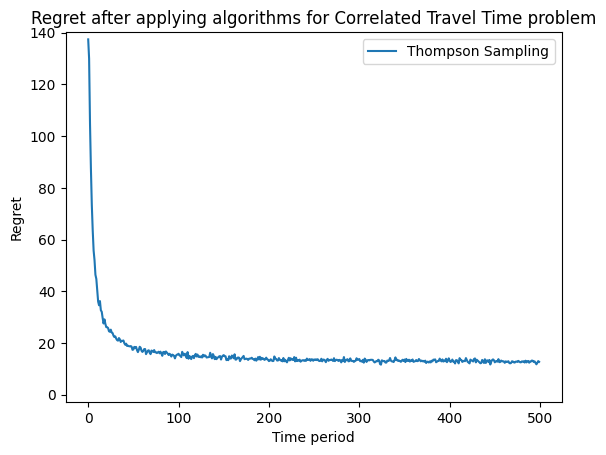

In [ ]:
n_trials = 10000
lower_bound, upper_bound = 0, 0
lower_bound, upper_bound = plot_regret(n_trials, 500, CorrelatedTravelTimeSolution, [6], lower_bound, upper_bound)

lower_bound -= (upper_bound - lower_bound) / 50
upper_bound += (upper_bound - lower_bound) / 50
plt.ylim(top=upper_bound)
plt.ylim(bottom=lower_bound)

plt.ylabel('Regret')
plt.xlabel('Time period')
plt.legend(["Thompson Sampling"])
plt.title("Regret after applying algorithms for Correlated Travel Time problem")
plt.show()